# Trabajo práctico 1

## 7506-Organización de datos. 1/2018

### Alumnos: Sebastian Leonardi
### Fernando Pazos
### José Sanchez
### Romina Zatryracz

### importación de las herramientas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### lectura de los datos

In [2]:
df_post_edu=pd.read_csv('fiuba_1_postulantes_educacion.csv')
df_post_gen=pd.read_csv('fiuba_2_postulantes_genero_y_edad.csv')
#df_vistas=pd.read_csv('fiuba_3_vistas.csv')
df_postulaciones=pd.read_csv('fiuba_4_postulaciones.csv')
#df_avisos_online=pd.read_csv('fiuba_5_avisos_online.csv')
df_avisos_detalle=pd.read_csv('fiuba_6_avisos_detalle.csv')

## Análisis de los postulantes

Se realizará un análisis del perfil de los postulantes con la intención de que la empresa tenga conocimientos sobre las características de las personas que ingresan al sitio. Este conocimiento es fundamental tanto para focalizar la propaganda, personalizar diversos anuncios en la página, como para diseñar el propio perfil e inclusive el arte de la página.

No se analizará la base de datos de vistas, porque  en la base de datos de postulaciones hay registradas 3401623 postulaciones hechas entre el 15 de enero y el 28 de febrero. En la base de datos de las vistas hay registradas 961897 vistas hechas entre el 23 de febrero y el 1 de marzo. Por lo tanto la base de vistas está muy acotada, a sólo 6 días, concluyendo que la base de postulaciones tiene más representatividad sobre las personas que ingresan al sitio.

### Postulantes discriminados por edad

In [3]:
#Cálculo de la edad de los postulantes en base a la fecha de nacimiento
today=pd.to_datetime('2018/04/12')
fechanac=pd.Series(df_post_gen.fechanacimiento)
fechanac=pd.to_datetime(fechanac, errors='coerce')
edad=(today-fechanac)/np.timedelta64(365, 'D')    #edad expressada en años, devuelve un float
edad=edad[(edad>15)&(edad<80)]           #elimino edades <15 y >80 porque probablemente son errores
#paso los años a enteros para verlos en un gráfico de barras
edad=edad.astype("int64").value_counts().sort_index()

In [4]:
#agrego la columna edad a la tabla de postulantes como un float
edades=((today-pd.to_datetime(pd.Series(df_post_gen.fechanacimiento), errors='coerce'))/np.timedelta64(365, 'D'))
df_post_gen['edad']=edades

Text(0,0.5,'cantidad de postulaciones')

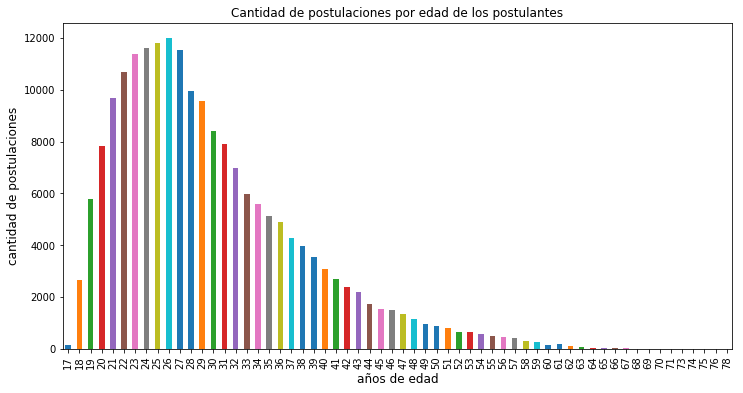

In [5]:
#grafica la cantidad de postulaciones por edad
plt.figure()
ax=edad.plot.bar(figsize=(12,6))
plt.title('Cantidad de postulaciones por edad de los postulantes')
plt.xlabel('años de edad',fontsize=12)
plt.ylabel('cantidad de postulaciones',fontsize=12)

Text(0,0.5,'cantidad de postulaciones')

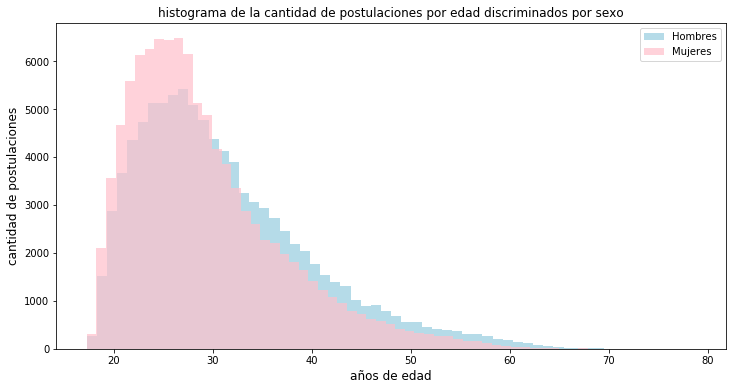

In [6]:
#histograma de la cantidad de postulaciones por distribución de edad discriminado por sexo, eliminando los postulantes con menos 
#de 15 años y los mayores de 80
plt.figure()
ax=df_post_gen.edad[(df_post_gen.edad>15)&(df_post_gen.edad<80)&(df_post_gen.sexo=='MASC')].plot.hist(bins=60,figsize=(12,6),color='lightblue', alpha=0.9 , label='Hombres',legend=True)
ax=df_post_gen.edad[(df_post_gen.edad>15)&(df_post_gen.edad<80)&(df_post_gen.sexo=='FEM')].plot.hist(bins=60,figsize=(12,6),color='pink', alpha=0.7 , label='Mujeres',legend=True)

plt.title("histograma de la cantidad de postulaciones por edad discriminados por sexo")
plt.xlabel("años de edad",fontsize=12)
plt.ylabel("cantidad de postulaciones",fontsize=12)

### Postulantes discriminados por educación

Como los postulantes en muchos casos no declararon un único nivel de educación, se seleccionará el más alto de acuerdo al siguiente orden:

Secundario/Otro - Terciario - Universitario - Posgrado - Master - Doctorado

y dentro de cada categoría el orden es:

abandonado - en curso - graduado

In [7]:
#Como no hay una única declaración de estudios, se puntuará los estudios declarados por nivel del curso y estado del curso
df_curso=pd.DataFrame({'nombre':pd.Categorical(['Secundario','Otro','Terciario/Técnico','Universitario','Posgrado','Master','Doctorado']),'puntos':[0,0,3,6,9,12,15]})
df_estado=pd.DataFrame({'estado':pd.Categorical(['Abandonado','En Curso','Graduado']),'puntos2':[0,1,2]})

In [8]:
#se juntan las tablas de postulaciones y valor del nombre del curso
df_post_edu_unico=pd.merge(df_post_edu,df_curso,on='nombre')

In [9]:
#y valor del estado del curso
df_post_edu_unico=pd.merge(df_post_edu_unico,df_estado,on='estado')

In [10]:
#se cuantifica el curso con un valor preestablecido
df_post_edu_unico['valor_educ']=df_post_edu_unico.puntos+df_post_edu_unico.puntos2

In [11]:
#se ordena por valor del curso
df_post_edu_unico=df_post_edu_unico.iloc[:,[0,1,2,5]].sort_values(by='valor_educ',ascending=False)

In [12]:
#elimina a los repetidos posteriores (o sea, se queda con el primero que es el del valor más alto)
df_post_edu_unico=df_post_edu_unico.drop_duplicates('idpostulante')

In [13]:
df_post_edu_unico.iloc[:,0:3].sort_values(by='idpostulante').head(10)

,idpostulante,nombre,estado
218135,0z5VvGv,Secundario,Graduado
155130,0zB026d,Terciario/Técnico,Graduado
65358,0zB03O9,Terciario/Técnico,En Curso
200251,0zB08lq,Secundario,Graduado
102536,0zB0NWY,Universitario,Graduado
20608,0zB0Xwd,Universitario,En Curso
280619,0zB0YGv,Universitario,Abandonado
20619,0zB0e1d,Universitario,En Curso
155162,0zB0eDY,Terciario/Técnico,Graduado
131044,0zB0qGE,Otro,Graduado


#### Gráfico de educación de los postulantes siendo que se considera sólo el nivel más alto declarado

In [14]:
#define una tabla por curso y estado del curso
df=pd.DataFrame({'curso':df_post_edu_unico.nombre,'estado':df_post_edu_unico.estado,'q':1})

In [15]:
df=pd.crosstab(df_post_edu_unico.nombre,df_post_edu_unico.estado)
    #crea una columna de total de postulantes por curso con el objetivo de ordenar del curso más estudiado 
    #al menos estudiado en orden decreciente
df['total']=df.T.sum()
df=df.sort_values(by='total',ascending=False)
    #elimina la columna del total de avisos
df=df.iloc[:,0:3] 

Text(0,0.5,'cantidad de postulantes')

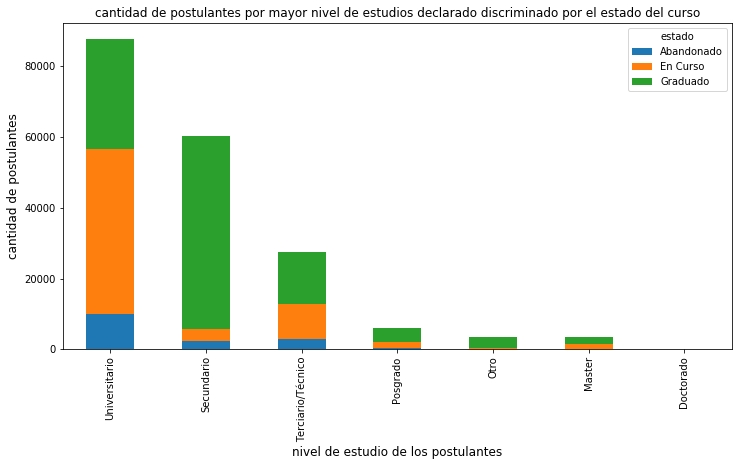

In [16]:
#grafica las barras empiladas por curso y estado
plt.figure()
df.plot.bar(stacked=True,figsize=(12,6))
plt.title('cantidad de postulantes por mayor nivel de estudios declarado discriminado por el estado del curso')
plt.xlabel('nivel de estudio de los postulantes',fontsize=12)
plt.ylabel('cantidad de postulantes',fontsize=12)

In [17]:
print('cantidad total de postulantes:',len(df_post_edu_unico))

cantidad total de postulantes: 188752


## Análisis de las áreas

Se realizará un análisis de las diferentes áreas ofertadas en los avisos, con el objetivo que la empresa pueda conocer aquellas áreas donde hay menos postulaciones por aviso, con la intención de que hacia allí puedan direccionarse los esfuerzos por aumentar el número de postulaciones, através de propaganda, promociones, entre otras estrategias comerciales.

In [18]:
#cantidad de avisos por área
avisos_x_area=pd.Series(df_avisos_detalle.nombre_area.value_counts())
media_avisos_x_area=len(df_avisos_detalle)/len(avisos_x_area)

Se desconsideran las áreas que no tienen una cantidad de avisos superior al 25% de la media de avisos

In [19]:
#desconsidera las áreas que no tienen una cantidad de avisos superior al 25% de la media de avisos
avisos_x_area=avisos_x_area[avisos_x_area>media_avisos_x_area/4]
#df=pd.DataFrame({'area':avisos_x_area.index,'valor':list(avisos_x_area)},index=range(len(avisos_x_area)))
#df[df.valor>media_avisos_x_area/4]
avisos_x_area.sort_index()

Abastecimiento                           56
Administración                          901
Administración de Personal              152
Almacén / Depósito / Expedición         184
Análisis Funcional                      100
Análisis de Riesgos                      30
Arquitectura                             69
Asistente                                22
Atención al Cliente                     347
Auditoría                                68
Business Intelligence                    51
Cadetería                                43
Calidad                                  94
Call Center                             191
Camareros                                48
Capacitación                             32
Comercial                               983
Community Management                     21
Compensación y Planilla                  32
Compras                                 170
Compras Internacionales/Importación      53
Comunicacion                             23
Construcción                    

### Análisis de las postulaciones por área

 Se eliminan postulaciones a avisos que no están en la lista de avisos detallada

In [20]:
#postulaciones por aviso excluyendo las postulaciones a avisos que no están en la base df_avisos_detalle
post_x_aviso=pd.Series(df_postulaciones[df_postulaciones.idaviso.isin(df_avisos_detalle.idaviso)].idaviso.value_counts().sort_index())

In [21]:
#avisos con cero postulaciones
avisos_no_postulados=pd.Series(df_avisos_detalle[~df_avisos_detalle.idaviso.isin(df_postulaciones.idaviso)].idaviso.value_counts()-1)

In [22]:
#postulaciones por aviso incluyendo aquellos avisos con cero postulaciones
post_x_aviso=post_x_aviso.append(avisos_no_postulados).sort_index()

In [23]:
df_avisos_detalle=df_avisos_detalle.sort_values(by='idaviso')

In [24]:
#se agrega una columna a la tabla con las postulaciones por aviso, incluyendo un cero en aquellos avisos no postulados por nadie
df_avisos_detalle['post_x_aviso']=post_x_aviso.data

##### Avisos con la mayor cantidad de postulaciones

In [25]:
df_avisos_detalle.sort_values(by='post_x_aviso',ascending=False).iloc[:,[0,2,3,4,7,8,9,10,11]].head(10)

,idaviso,titulo,descripcion,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,post_x_aviso
2995,1112033906,Cajero/a-Repositor/a (Capital Federal),<p>Te estamos buscando para formar parte de nu...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Ventas,Farmacity,9932
13003,1112334791,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial,Farmacity,9787
11443,1112204682,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial,Farmacity,9244
3029,1112094756,Representante de Atencion al Cliente/ Banco,<p>Seleccionaremos para Importante Entidad Ban...,Gran Buenos Aires,Part-time,Senior / Semi-Senior,Call Center,RANDSTAD,8763
2127,1112345900,Asesores de Atención al Público - Part time,<p><em><strong>¡Sumate al equipo UP!</strong><...,Capital Federal,Part-time,Junior,Atención al Cliente,Universidad de Palermo,8304
9749,1112319451,Cajera/o (Capital Federal / Zona Norte),<p><strong>¡En FRÁVEGA tenemos nuevas OPORTUNI...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Créditos y Cobranzas,Frávega,8025
4419,1112298966,Representante de Atención al Cliente - Call C...,"<p><span lang=""ES"" style="""">Incorporaremos a n...",Gran Buenos Aires,Full-time,Junior,Call Center,Fundación Favaloro,7637
11937,1112262494,OPERADORES TELEFÓNICOS DE ATENCIÓN AL CLIENTE,"<p style="""">Buscamos Operadores Telefónicos pa...",Gran Buenos Aires,Part-time,Senior / Semi-Senior,Atención al Cliente,BBVA Francés,7541
6737,1112305277,CAJERO/A PART TIME - CABA,<p>Orientamos nuestra búsqueda a estudiantes ...,Gran Buenos Aires,Full-time,Junior,Tesorería,BBVA Francés,7153
4288,1112296264,Recepcionista Administrativa - Part Time,<p>Entre sus tareas mas importantes se encuent...,Gran Buenos Aires,Full-time,Junior,Recepcionista,Roilands Real Estate,6968


In [26]:
#postulaciones por área considerando las áreas que tienen más del 25% de la media de avisos
postulaciones_x_area=df_avisos_detalle[df_avisos_detalle.nombre_area.isin(avisos_x_area.index)].groupby('nombre_area').sum().iloc[:,2]

In [27]:
#tasa de postulaciones/avisos en cada área
tasa_post_x_avisos=postulaciones_x_area/avisos_x_area

### Tasa de postulaciones por avisos en cada área 

In [28]:
df_tasa=pd.DataFrame({'avisos':avisos_x_area,'postulaciones':postulaciones_x_area,'tasa_postulaciones_x_aviso':tasa_post_x_avisos},index=tasa_post_x_avisos.sort_values(ascending=False).index)

In [29]:
df_tasa.head(20)

,avisos,postulaciones,tasa_postulaciones_x_aviso
Recepcionista,151,137485,910.496689
Secretaria,46,39188,851.913043
Asistente,22,17272,785.090909
Call Center,191,126430,661.937173
Telemarketing,138,87506,634.101449
Tesorería,137,78450,572.627737
Camareros,48,27482,572.541667
Atención al Cliente,347,195636,563.792507
Mantenimiento y Limpieza,141,63308,448.992908
Cadetería,43,19290,448.604651


#### Gráfico de la tasa de postulaciones por aviso en las 20 áreas con mayor tasa de postulaciones/aviso

In [30]:
df_tasa_mayor=df_tasa.head(20).sort_index()

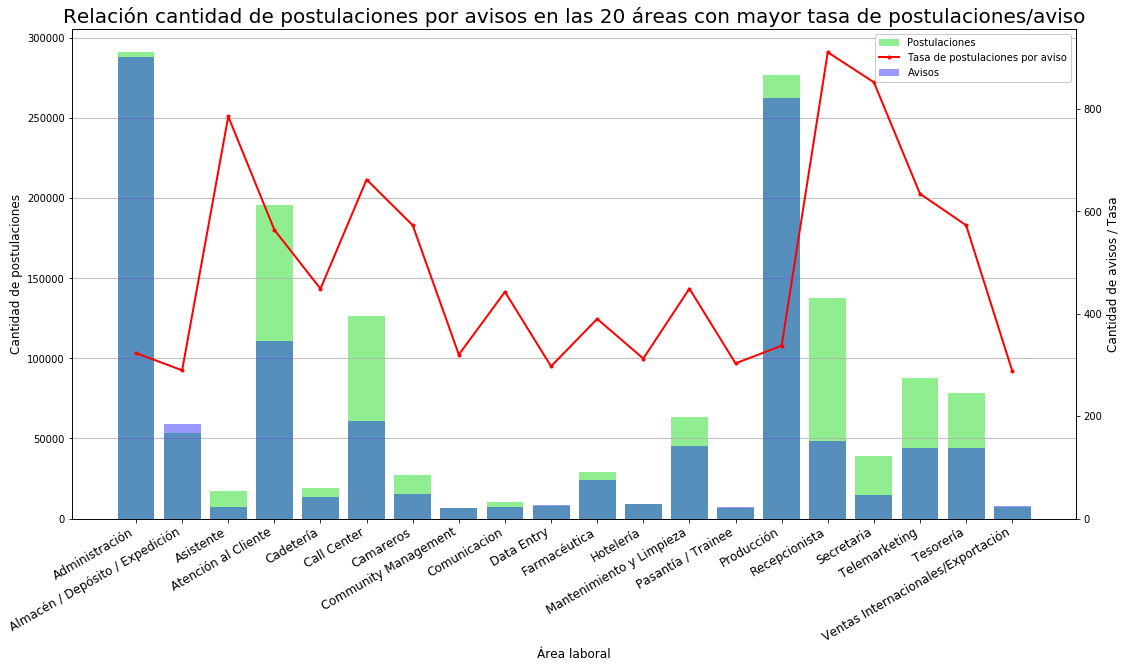

In [31]:
fig, ax = plt.subplots(figsize=(18, 10))
fig.autofmt_xdate()

ax.bar(df_tasa_mayor.index.get_values(), df_tasa_mayor['postulaciones'], color='lightgreen', label='Postulaciones')
ax2 = ax.twinx()
ax2.bar(df_tasa_mayor.index.get_values(), df_tasa_mayor['avisos'], color='blue', alpha=.4, label='Avisos')
ax2.plot(df_tasa_mayor.index.get_values(), df_tasa_mayor['tasa_postulaciones_x_aviso'], '.-', c='red', linewidth=2, label='Tasa de postulaciones por aviso')

# See https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend#answer-47370214
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2, loc=1, framealpha=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.title('Relación cantidad de postulaciones por avisos en las 20 áreas con mayor tasa de postulaciones/aviso', fontdict={'size':20})

ax.grid(axis='y')

ax.set_xlabel('Área laboral',fontsize=12)
ax.set_ylabel('Cantidad de postulaciones',fontsize=12)
ax2.set_ylabel('Cantidad de avisos / Tasa',fontsize=12)

ax.set_xticks(range(len(df_tasa_mayor)))
ax.set_xticklabels(df_tasa_mayor.index, fontdict={'size':12})

plt.show()

Text(0,0.5,'área laboral')

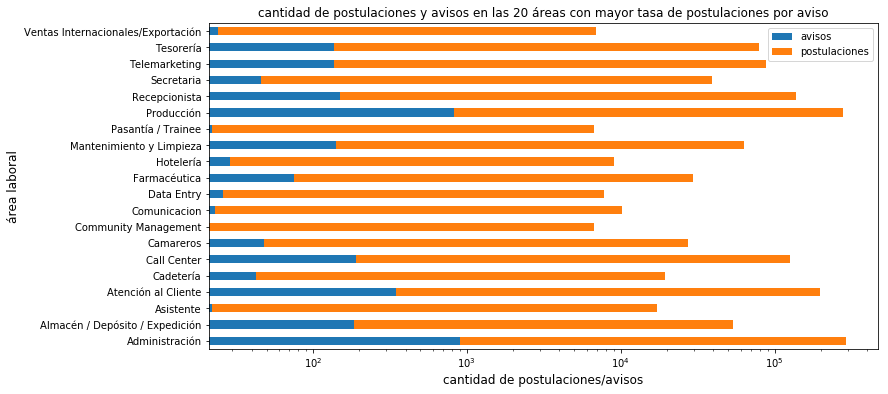

In [32]:
plt.figure()
df_tasa_mayor.iloc[:,[0,1]].plot.barh(stacked=True,figsize=(12,6),logx=True)
plt.title('cantidad de postulaciones y avisos en las 20 áreas con mayor tasa de postulaciones por aviso')
plt.xlabel('cantidad de postulaciones/avisos',fontsize=12)
plt.ylabel('área laboral',fontsize=12)

#### Gráfico de la tasa de postulaciones por aviso en las 20 áreas con menor tasa de postulaciones/aviso

In [33]:
df_tasa.tail(20)

,avisos,postulaciones,tasa_postulaciones_x_aviso
Construcción,97,9158,94.412371
Educación/ Docentes,20,1837,91.850000
Ingeniería Civil,48,4369,91.020833
Otras Ingenierias,50,4434,88.680000
Mantenimiento,324,28462,87.845679
Organización y Métodos,22,1880,85.454545
Oficios y Profesiones,209,17770,85.023923
Seguridad Informática,20,1668,83.400000
Ingeniería Eléctrica y Electrónica,72,5413,75.180556
Ingeniería Electromecánica,33,2385,72.272727


In [34]:
df_tasa_menor=df_tasa.tail(20).sort_index()

Text(0,0.5,'área laboral')

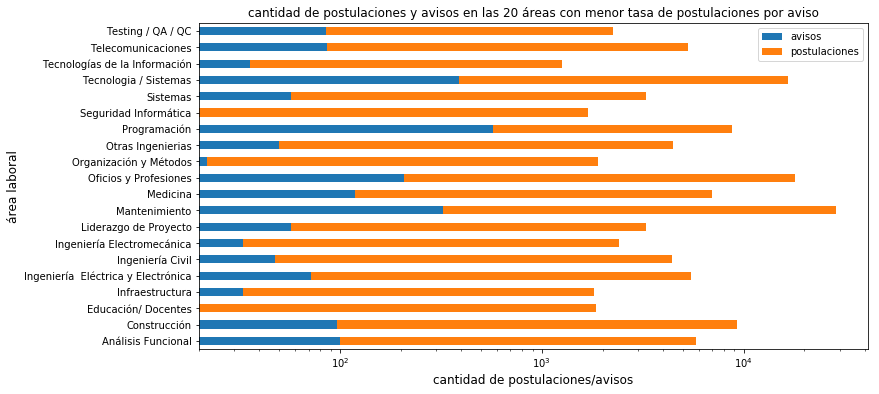

In [35]:
plt.figure()
df_tasa_menor.iloc[:,[0,1]].plot.barh(stacked=True,figsize=(12,6),logx=True)
plt.title('cantidad de postulaciones y avisos en las 20 áreas con menor tasa de postulaciones por aviso')
plt.xlabel('cantidad de postulaciones/avisos',fontsize=12)
plt.ylabel('área laboral',fontsize=12)

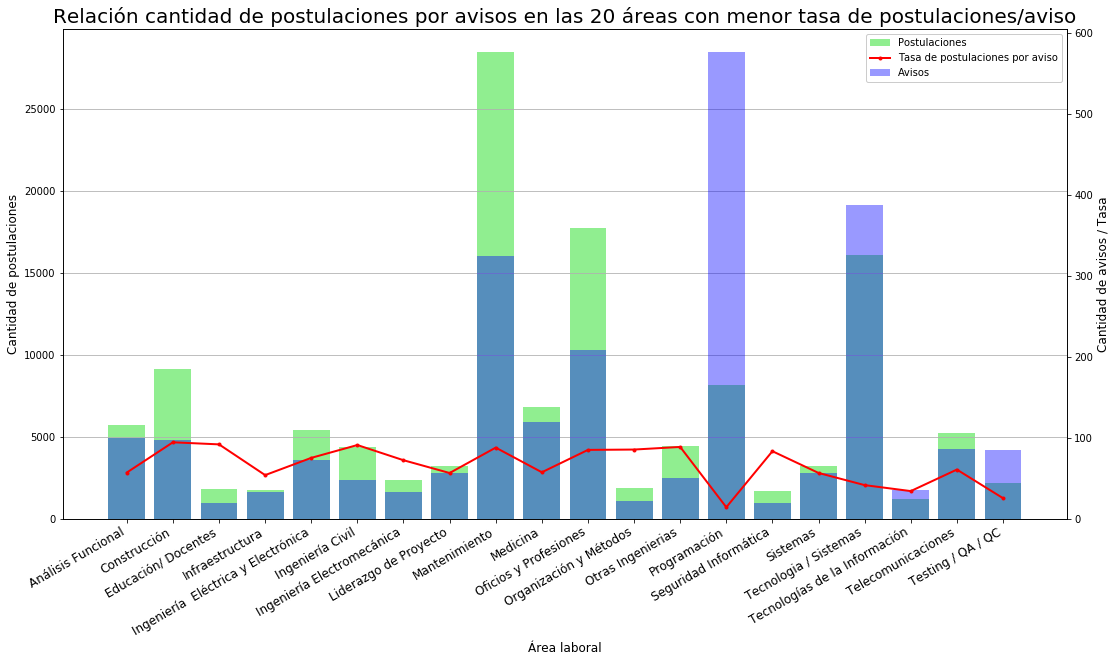

In [36]:
fig, ax = plt.subplots(figsize=(18, 10))
fig.autofmt_xdate()

ax.bar(df_tasa_menor.index.get_values(), df_tasa_menor['postulaciones'], color='lightgreen', label='Postulaciones')
ax2 = ax.twinx()
ax2.bar(df_tasa_menor.index.get_values(), df_tasa_menor['avisos'], color='blue', alpha=.4, label='Avisos')
ax2.plot(df_tasa_menor.index.get_values(), df_tasa_menor['tasa_postulaciones_x_aviso'], '.-', c='red', linewidth=2, label='Tasa de postulaciones por aviso')

# See https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend#answer-47370214
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2, loc=1, framealpha=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.title('Relación cantidad de postulaciones por avisos en las 20 áreas con menor tasa de postulaciones/aviso', fontdict={'size':20})

ax.grid(axis='y')

ax.set_xlabel('Área laboral',fontsize=12)
ax.set_ylabel('Cantidad de postulaciones',fontsize=12)
ax2.set_ylabel('Cantidad de avisos / Tasa',fontsize=12)

ax.set_xticks(range(len(df_tasa_menor)))
ax.set_xticklabels(df_tasa_menor.index, fontdict={'size':12})

plt.show()

#### Gráfico de la relación entre cantidad de avisos y postulaciones

Analizamos la relacion lineal entre estas dos variables. Podemos observar una fuerte correlatividad, lo cual nos invita a postular la hipotesis de que un Area con mayor numero de avisos podria tener mayor cantidad de postulaciones. Lo anterior podria contrastarse a traves de una prueba de hipotesis, variando la cantidad de avisos y observando como responden las postulaciones.

In [111]:
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score
#from sklearn.preprocessing import MinMaxScaler

In [ ]:
#linear = LinearRegression()
#linear.fit(df.avisos, df.postulaciones)
#pred_y = linear.predict(df.loc(['avisos','postulaciones']))

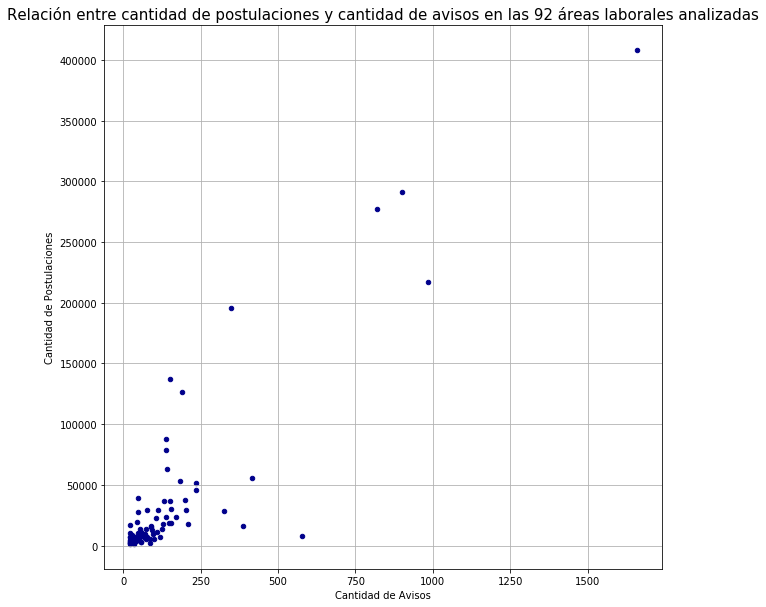

In [37]:
ax = df_tasa.plot.scatter(x='avisos', y='postulaciones', color='DarkBlue',figsize=(10,10))

#fig, ax = plt.subplots(figsize=(12, 12))
#ax.scatter(df_tasa.avisos, df_tasa.postulaciones, alpha=.8, c='r', label='Área laboral')
#ax.plot(df_tasa.avisos, pred_y, label='Relación Lineal (R^2 = %.2f)' % r2_score(df_tasa.postulaciones, pred_y))

ax.grid()

plt.title('Relación entre cantidad de postulaciones y cantidad de avisos en las 92 áreas laborales analizadas', fontdict={'size':15})
plt.xlabel('Cantidad de Avisos')
plt.ylabel('Cantidad de Postulaciones')

#plt.legend()

plt.show()

## Análisis de las edades de los postulantes por área

In [38]:
#agrego a la tabla de postulaciones el sexo y la edad de los postulantes. Considero sólo aquellas postulaciones a avisos que 
#están en la tabla avisos_detalle y descartando las edades menor a 15 y mayor que 80
df_postulaciones=pd.merge(df_postulaciones[df_postulaciones.idaviso.isin(df_avisos_detalle.idaviso)],df_post_gen[(df_post_gen.edad>15)&(df_post_gen.edad<80)].loc[:,['idpostulante','sexo','edad']],on='idpostulante')

In [39]:
#agrego también el área del aviso al que se postula
df_postulaciones=pd.merge(df_postulaciones,df_avisos_detalle[['idaviso','nombre_area']],on='idaviso')

In [40]:
# y ya que estoy agrego también la educación
df_postulaciones=pd.merge(df_postulaciones,df_post_edu_unico,on='idpostulante')

In [41]:
df_postulaciones.sort_values(by='idaviso').head(4)

,idaviso,idpostulante,fechapostulacion,sexo,edad,nombre_area,nombre,estado,valor_educ
1894156,8725750,1qwDrO,2018-02-01 14:48:14,MASC,58.427397,Comercial,Posgrado,Graduado,11
2035340,8725750,xkpORwz,2018-01-15 15:04:26,MASC,23.901370,Comercial,Universitario,En Curso,7
2888027,8725750,JBxVqEk,2018-02-04 20:32:30,FEM,39.980822,Comercial,Terciario/Técnico,Abandonado,3
2756687,8725750,lDLa0LM,2018-02-02 17:19:17,MASC,27.131507,Comercial,Universitario,En Curso,7


#### Heatmap de edad por área para las 20 áreas con menor / mayor tasa de postulaciones por aviso

In [42]:
#crea un df provisorio para hacer el heatmap de edades por área
df=pd.DataFrame({'nombre_area':df_postulaciones.nombre_area,'edad':df_postulaciones.edad.astype("int64"),'q':1},index=range(len(df_postulaciones)))

In [43]:
df=pd.pivot_table(df,index=df.nombre_area,columns=df.edad,values='q', aggfunc='count').fillna(0)


Text(32.5,0.5,'Area Laboral')

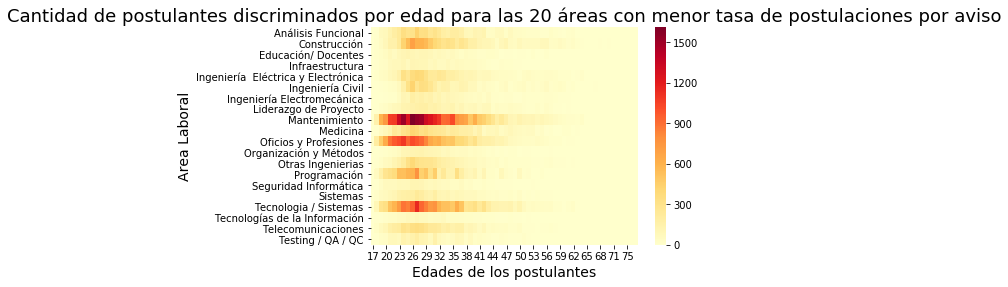

In [44]:
ax = sns.heatmap(df[df.index.isin(df_tasa_menor.index)],  cmap='YlOrRd')
ax.set_title("Cantidad de postulantes discriminados por edad para las 20 áreas con menor tasa de postulaciones por aviso", fontsize=18)
ax.set_xlabel("Edades de los postulantes",fontsize=14)
ax.set_ylabel("Area Laboral", fontsize=14)

Text(32.5,0.5,'Area Laboral')

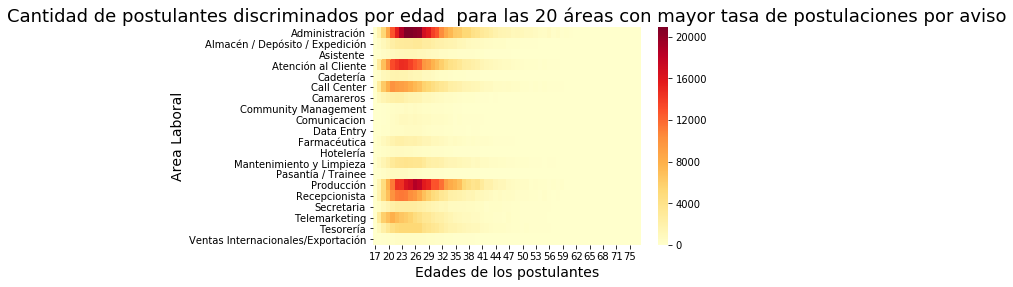

In [45]:
ax = sns.heatmap(df[df.index.isin(df_tasa_mayor.index)],  cmap='YlOrRd')
ax.set_title("Cantidad de postulantes discriminados por edad  para las 20 áreas con mayor tasa de postulaciones por aviso", fontsize=18)
ax.set_xlabel("Edades de los postulantes",fontsize=14)
ax.set_ylabel("Area Laboral", fontsize=14)

#### Edades mínima, media y máxima por área

In [46]:
#calculo la edad media, mínima y máxima de edades por área. Siempre descartando las edades menores a 15 y mayores a 80
edades_x_area=df_postulaciones[['nombre_area','edad']].groupby('nombre_area').mean()
edades_x_area['minima']=df_postulaciones[['nombre_area','edad']].groupby('nombre_area').min()
edades_x_area['maxima']=df_postulaciones[['nombre_area','edad']].groupby('nombre_area').max()

In [47]:
#edades por área en las 20 áreas con menor tasa de postilaciones por aviso
print('edades por área en las 20 áreas con menor tasa de postilaciones por aviso' )
edades_x_area[edades_x_area.index.isin(df_tasa_menor.index)]

edades por área en las 20 áreas con menor tasa de postilaciones por aviso


,edad,minima,maxima
nombre_area,,,
Análisis Funcional,32.149527,17.917808,62.791781
Construcción,33.516890,17.884932,75.791781
Educación/ Docentes,31.371563,18.158904,68.876712
Infraestructura,31.468975,18.512329,59.857534
Ingeniería Eléctrica y Electrónica,33.129279,18.227397,75.791781
Ingeniería Civil,33.821866,18.720548,73.742466
Ingeniería Electromecánica,34.075794,18.980822,67.323288
Liderazgo de Proyecto,34.286620,18.161644,67.369863
Mantenimiento,31.423695,17.298630,71.871233


In [48]:
#edades por área en las 20 áreas con mayor tasa de postilaciones por aviso
print('edades por área en las 20 áreas con mayor tasa de postilaciones por aviso' )
edades_x_area[edades_x_area.index.isin(df_tasa_mayor.index)]

edades por área en las 20 áreas con mayor tasa de postilaciones por aviso


,edad,minima,maxima
nombre_area,,,
Administración,29.606252,17.298630,76.608219
Almacén / Depósito / Expedición,29.841308,17.487671,73.460274
Asistente,29.135012,17.857534,70.832877
Atención al Cliente,27.792476,17.386301,69.567123
Cadetería,26.155558,17.802740,67.805479
Call Center,27.562942,17.575342,76.608219
Camareros,26.165347,17.487671,67.805479
Community Management,27.847741,18.095890,59.435616
Comunicacion,28.567820,17.868493,63.172603


#### Edad promedio de postulaciones por aviso

In [49]:
#edad media de postulaciones por aviso
media_edad_x_aviso=df_postulaciones.loc[:,['idaviso','edad']].groupby('idaviso').mean()
#se agrega esa media de edad por aviso a la tabla de avisos_detalle
df_edad_x_aviso=pd.DataFrame({'idaviso':media_edad_x_aviso.index,'media_edad':media_edad_x_aviso.edad.data},index=range(len(media_edad_x_aviso)))
df_avisos_detalle=pd.merge(df_avisos_detalle,df_edad_x_aviso[['idaviso','media_edad']],on='idaviso')

In [50]:
df_avisos_detalle.iloc[:,[0,3,4,9,10,11,12]]

,idaviso,descripcion,nombre_zona,nombre_area,denominacion_empresa,post_x_aviso,media_edad
0,8725750,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,Comercial,VENTOR,117,30.357955
1,12543760,"<p>Buscamos un perfil dinámico, proactivo y co...",Gran Buenos Aires,Diseño Gráfico,Establecimiento Las Marías,986,29.649915
2,12812680,<p>Importante empresa de consumo masivo selecc...,Gran Buenos Aires,Otros,Grupo Gestión,115,25.313609
3,1000132160,<p><strong>para integrarse a equipos de desarr...,Gran Buenos Aires,Programación,Open Solutions Argentina S.A.,11,35.249315
4,1000365356,<p>Para importante empresa de personal eventua...,Gran Buenos Aires,Selección,Consultores de Empresas SRL,256,29.716643
5,1000365835,<p>Somos una empresa multinacional que opera e...,Gran Buenos Aires,Ventas,Wurth Argentina S.A,96,32.372093
6,1000371968,<p>Somos una empresa multinacional que opera e...,Gran Buenos Aires,Ventas,Wurth Argentina S.A,15,30.763209
7,1000375329,<p>Importante empresa de Informática y Distrib...,Capital Federal,Tecnologia / Sistemas,Seincomp Informatica,310,30.555477
8,1000467083,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,Ventas,Wurth Argentina S.A,21,38.755205
9,1000468151,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,Ventas,Wurth Argentina S.A,32,35.454919


## Análisis de la educación de los postulantes por área

In [51]:
#dafa frame provisorio para realizar heatmap de la educación de los estudiantes por área laboral
df=df_postulaciones[['nombre_area','valor_educ']]
df['q']=1
df=pd.pivot_table(df,index=df.nombre_area,columns=df.valor_educ,values='q', aggfunc='sum').fillna(0)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
#renombro als columnas como categóricas
df.columns=['Secundario/Otro abandonado','Secundario/Otro en curso','Secundario/Otro graduado','Terciario/Técnico abandonado','Terciario/Técnico en curso','Terciario/Técnico graduado','Universitario abandonado','Universitario en curso','Universitario graduado','Posgrado abandonado','Posgrado en curso','Posgrado graduado','Master abandonado','Master en curso','Master graduado','Doctorado abandonado','Doctorado en curso','Doctorado graduado']

In [53]:
#cantidad de postulantes por nivel de estudios en cada área
print('cantidad de postulantes por nivel de estudios en cada área')
df.head(4)

cantidad de postulantes por nivel de estudios en cada área


,Secundario/Otro abandonado,Secundario/Otro en curso,Secundario/Otro graduado,Terciario/Técnico abandonado,Terciario/Técnico en curso,Terciario/Técnico graduado,Universitario abandonado,Universitario en curso,Universitario graduado,Posgrado abandonado,Posgrado en curso,Posgrado graduado,Master abandonado,Master en curso,Master graduado,Doctorado abandonado,Doctorado en curso,Doctorado graduado
nombre_area,,,,,,,,,,,,,,,,,,
Abastecimiento,169.0,283.0,4803.0,173.0,495.0,692.0,483.0,2007.0,1092.0,9.0,66.0,156.0,14.0,58.0,82.0,1.0,2.0,3.0
Administracion de Seguros,8.0,16.0,737.0,81.0,251.0,342.0,299.0,1461.0,987.0,6.0,42.0,111.0,3.0,37.0,30.0,0.0,2.0,2.0
Administración,577.0,1006.0,49623.0,4394.0,15901.0,21958.0,19455.0,107492.0,53370.0,450.0,2089.0,4947.0,229.0,1616.0,1927.0,10.0,191.0,84.0
Administración de Base de Datos,0.0,0.0,73.0,6.0,32.0,23.0,20.0,172.0,135.0,0.0,15.0,11.0,1.0,10.0,8.0,0.0,1.0,1.0


#### Heatmap de edad por área para las 20 áreas con menor / mayor tasa de postulaciones por aviso

Text(32.5,0.5,'Area Laboral')

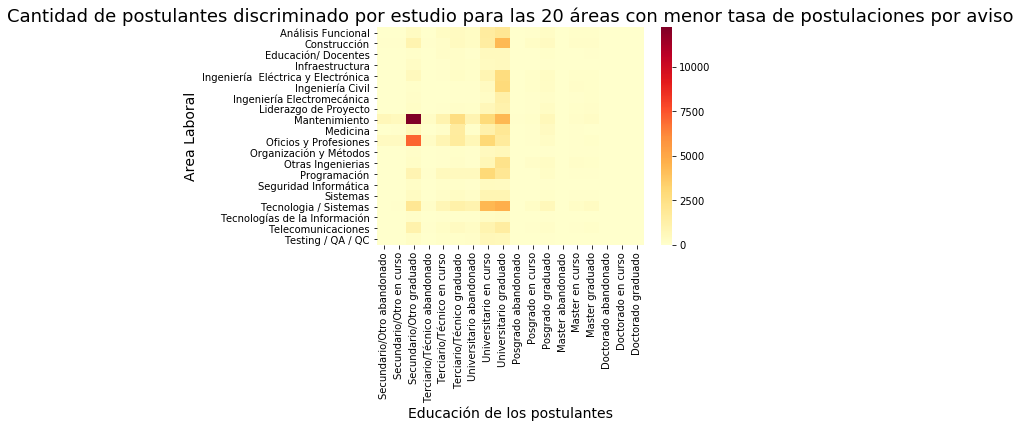

In [54]:
ax = sns.heatmap(df[df.index.isin(df_tasa_menor.index)],  cmap='YlOrRd')
ax.set_title("Cantidad de postulantes discriminado por estudio para las 20 áreas con menor tasa de postulaciones por aviso", fontsize=18)
ax.set_xlabel("Educación de los postulantes",fontsize=14)
ax.set_ylabel("Area Laboral", fontsize=14)

Text(32.5,0.5,'Area Laboral')

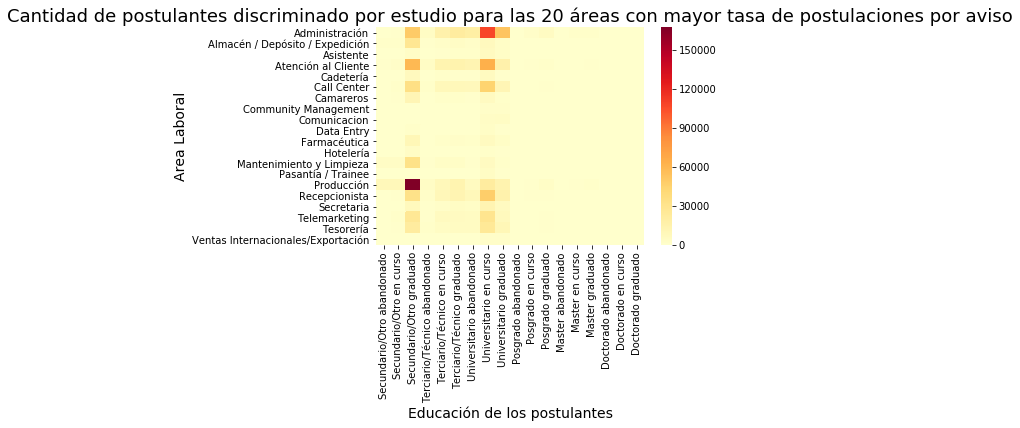

In [55]:
ax = sns.heatmap(df[df.index.isin(df_tasa_mayor.index)],  cmap='YlOrRd')
ax.set_title("Cantidad de postulantes discriminado por estudio para las 20 áreas con mayor tasa de postulaciones por aviso", fontsize=18)
ax.set_xlabel("Educación de los postulantes",fontsize=14)
ax.set_ylabel("Area Laboral", fontsize=14)

## Análisis de las empresas

In [56]:
#cantidad de avisos por empresa
avisos_x_empresa=pd.Series(df_avisos_detalle.denominacion_empresa.value_counts())

In [57]:
#similarmente, también eliminaremos las empresas que tienen menos del 25% del promedio de avisos por empresa
#elimina sólo las que tienen 1 aviso
media_avisos_x_empresa=len(df_avisos_detalle)/len(avisos_x_empresa)
#avisos_x_empresa=avisos_x_empresa[avisos_x_empresa>media_avisos_x_empresa/4]

In [58]:
postulaciones_x_empresa=df_avisos_detalle[df_avisos_detalle.denominacion_empresa.isin(avisos_x_empresa.index)].groupby('denominacion_empresa').sum()
postulaciones_x_empresa=postulaciones_x_empresa.iloc[:,2].sort_values(ascending=False)

In [59]:
#tasa de postulaciones/avisos en cada empresa
tasa_post_x_empresa=postulaciones_x_empresa.sort_index()/avisos_x_empresa.sort_index()

### Tasa de postulaciones por aviso em cada empresa

In [60]:
tasa_post_x_empresa.sort_values(ascending=False)

denominacion_empresa
Universidad de Palermo                                                          8304.000000
Grupo Arcor                                                                     5432.000000
Medical Hair Instituto de Implantes y Medicina Capilar SRL                      5298.000000
COMDATA ARGENTINA SA                                                            5062.000000
Servicios Mapsay SRL                                                            4183.000000
Naranja                                                                         3614.000000
Maternelle                                                                      3436.000000
Remax                                                                           3356.000000
MSM LEasing                                                                     3110.000000
47 street                                                                       3085.500000
RAMALLO OSCAR ALBERTO                                      

#### Gráfico de la tasa de postulaciones por aviso en las 20 empresas con mayor tasa de postulaciones/aviso

In [61]:
df=pd.DataFrame({'avisos':avisos_x_empresa,'postulaciones':postulaciones_x_empresa},index=tasa_post_x_empresa.sort_values(ascending=False).head(20).index)

In [62]:
df

,avisos,postulaciones
denominacion_empresa,,
Universidad de Palermo,1,8304
Grupo Arcor,1,5432
Medical Hair Instituto de Implantes y Medicina Capilar SRL,1,5298
COMDATA ARGENTINA SA,1,5062
Servicios Mapsay SRL,1,4183
Naranja,2,7228
Maternelle,1,3436
Remax,1,3356
MSM LEasing,1,3110


Text(0,0.5,'empresas')

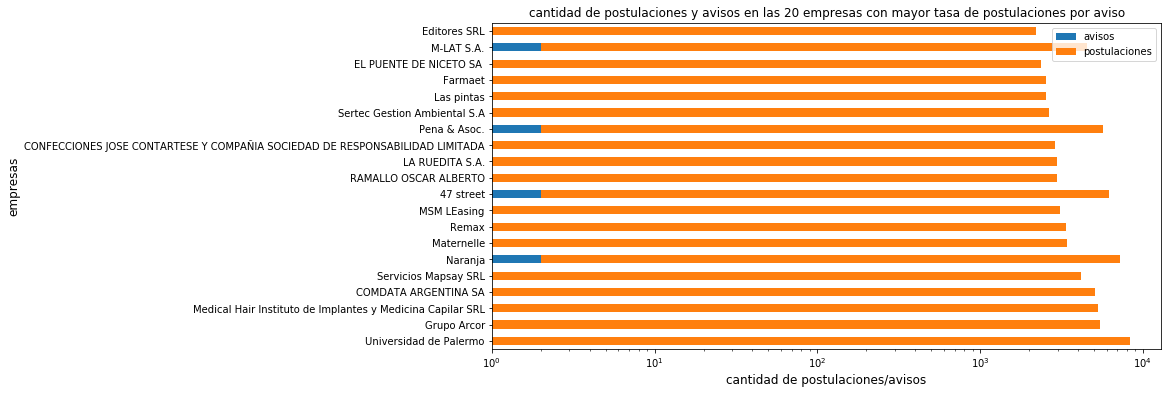

In [63]:
plt.figure()
df.plot.barh(stacked=True,figsize=(12,6),logx=True)
plt.title('cantidad de postulaciones y avisos en las 20 empresas con mayor tasa de postulaciones por aviso')
plt.xlabel('cantidad de postulaciones/avisos',fontsize=12)
plt.ylabel('empresas',fontsize=12)